In [7]:
import numpy as np
import pylab as plt
import torch
from tqdm.auto import tqdm, trange
import scipy.linalg
import pandas as pd
import torchvision.datasets as dst

from common import gsave, gload
from nde.kernels import KernelPredictor, KernelType, load_mnist_all, CifarKernel

def joint_density(Y, L, nY=10, nL=10):
    C = np.zeros((nY, nL))
    for yhat, ell in zip(Y, L):
        C[yhat, ell] += 1
    C /= np.sum(C)
    return C

In [2]:
SETTING='mnist'
X, Y = load_mnist_all()
I_te = range(60000, 70000)
ker = KernelPredictor(X, Y)
ker.set_test(I_te) # set the test set.
y_te = Y[I_te]
N = 60000

In [3]:
## MNIST-implementation

# def train_pred(I_tr, y_tr):
#     return ker.train_pred(I_tr, y_tr=y_tr, ktype = KernelType.GAUSSIAN, sigma=0.15)

ktype = KernelType.GAUSSIAN
sigma = 0.15

Kte_all = ker.d_to_K(ker.D[I_te, :], ktype = ktype, sigma=sigma) 

def train_pred(I_tr, y_tr):
    model = ker.train(I_tr, y_tr=y_tr, ktype=ktype, sigma=sigma)
    Kte = Kte_all[:, I_tr]
    yhats = Kte.dot(model)
    preds = np.argmax(yhats, axis=1)
    return preds

In [4]:
def apply_noise(Y, confusion_matx):
    C = torch.Tensor(confusion_matx)  # C[i, j] = Pr[j --> i]
    Y_new = np.empty_like(Y)
    for i in range(len(Y)):
        y = Y[i]
        p = C[:, y]
        yNew = torch.distributions.categorical.Categorical(probs=p).sample()
        Y_new[i] = yNew
    return Y_new

/home/jupyter/ANONYMOUS-exp/nde/kernels/__init__.py:112: LinAlgWarning: Ill-conditioned matrix (rcond=5.10964e-08): result may not be accurate.
  model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
/home/jupyter/ANONYMOUS-exp/nde/kernels/__init__.py:112: LinAlgWarning: Ill-conditioned matrix (rcond=4.00515e-08): result may not be accurate.
  model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
/home/jupyter/ANONYMOUS-exp/nde/kernels/__init__.py:112: LinAlgWarning: Ill-conditioned matrix (rcond=2.88939e-08): result may not be accurate.
  model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
/home/jupyter/ANONYMOUS-exp/nde/kernels/__init__.py:112: LinAlgWarning: Ill-conditioned matrix (rcond=2.35465e-08): result may not be accurate.
  model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
/home/jupyter/ANONYMOUS-exp/nde/kernels/__init__.py:112: LinAlgWarning: Ill-conditioned matrix (rcond=1.85268e-08): result may not be accura

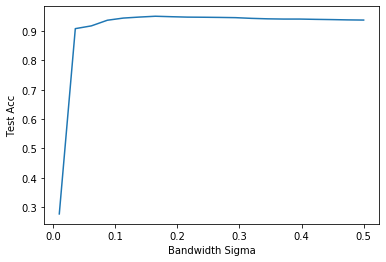

In [5]:
def get_acc(ntrain=2500, nte=5000, sigma=1.0, ktype=KernelType.GAUSSIAN):
    I_tr=range(ntrain)
    I_te=range(ntrain, ntrain+nte)
    ytrue= ker.y[I_te]
    preds = ker.predict(I_tr, I_te, ktype=ktype, sigma=sigma)
    return np.mean(preds == ytrue)

s = np.linspace(0.01, 0.5, 20)
accs = [get_acc(sigma=sig) for sig in tqdm(s)]
plt.plot(s, accs)
plt.ylabel('Test Acc');
plt.xlabel('Bandwidth Sigma');

In [36]:
## one-shot test

ntr = 5000
I_tr = np.random.choice(range(N), ntr, replace=False)

C = np.eye(10) # C[i, j] = Pr[j --> i]
C[0, 0] = 0.7
C[1, 0] = 0.3

y_tr_orig = np.copy(ker.y_tr[I_tr])
y_tr = apply_noise(y_tr_orig, C)

preds = train_pred(I_tr, y_tr)
print('test acc:', (preds == y_te).mean())

cm_te = joint_density(preds, y_te)
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.3f}'.format}) 
print(cm_te)

test acc: 0.9516
[[0.083 0.000 0.001 0.000 0.000 0.000 0.001 0.000 0.000 0.000]
 [0.014 0.113 0.000 0.000 0.000 0.000 0.001 0.001 0.000 0.001]
 [0.000 0.000 0.098 0.001 0.000 0.000 0.000 0.001 0.000 0.000]
 [0.000 0.000 0.001 0.097 0.000 0.001 0.000 0.000 0.001 0.001]
 [0.000 0.000 0.000 0.000 0.095 0.000 0.000 0.000 0.000 0.002]
 [0.000 0.000 0.000 0.001 0.000 0.086 0.001 0.000 0.001 0.001]
 [0.001 0.000 0.001 0.000 0.001 0.001 0.094 0.000 0.000 0.000]
 [0.000 0.000 0.001 0.001 0.000 0.000 0.000 0.098 0.000 0.001]
 [0.000 0.000 0.001 0.001 0.000 0.001 0.000 0.000 0.094 0.000]
 [0.000 0.000 0.000 0.001 0.002 0.000 0.000 0.002 0.000 0.095]]


In [34]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.3f}'.format}) 
print(cm_te)

[[0.090 0.000 0.001 0.000 0.000 0.000 0.000 0.000 0.001 0.000]
 [0.007 0.112 0.000 0.000 0.000 0.000 0.000 0.001 0.000 0.000]
 [0.000 0.000 0.100 0.000 0.000 0.000 0.000 0.001 0.000 0.000]
 [0.000 0.000 0.000 0.099 0.000 0.001 0.000 0.000 0.001 0.001]
 [0.000 0.000 0.000 0.000 0.096 0.000 0.000 0.000 0.000 0.001]
 [0.000 0.000 0.000 0.001 0.000 0.087 0.000 0.000 0.000 0.000]
 [0.001 0.000 0.000 0.000 0.000 0.001 0.094 0.000 0.000 0.000]
 [0.000 0.000 0.001 0.001 0.000 0.000 0.000 0.099 0.000 0.001]
 [0.000 0.000 0.001 0.001 0.000 0.000 0.000 0.000 0.094 0.000]
 [0.000 0.000 0.000 0.000 0.002 0.000 0.000 0.001 0.000 0.097]]


In [29]:
K = 100
ntr = 10000

C = np.eye(10) # C[i, j] = Pr[j --> i]
C[0, 0] = 0.6
C[1, 0] = 0.4

preds = np.empty((K, 10000), dtype=np.int8)
for i in trange(K):
    I_tr = np.random.choice(range(N), ntr, replace=False)
    y_tr_orig = np.copy(ker.y_tr[I_tr])
    y_tr = apply_noise(y_tr_orig, C)
    
    p = train_pred(I_tr, y_tr)
    preds[i] = p

In [30]:
gsave((preds, y_te, C), f'gs://ANONYMOUS/results/nde/kernels/pointwise_density/mnist_n{ntr}_targ01_64')